In [54]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import random

In [149]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )


In [55]:
# model building 
target_shape=(200,200)

In [56]:
### load dataset 

In [158]:
images_dir = '/home/tabasherarif/misc/Untitled Folder/CUB_200_2011/CUB_200_2011/images/'
birds_label = os.listdir(images_dir)

anchor_images = []
positive_images = []
labels=[]
for j in range(len(birds_label)):
    birds_images = os.listdir(os.path.join(images_dir, birds_label[j]))
    while (len(birds_images)>=2):
        idx1 = random.randint(0,len(birds_images)-1)
        img1_name = birds_images[idx1]
        birds_images.remove(img1_name)
        
        idx2 = random.randint(0,len(birds_images)-1)
        img2_name = birds_images[idx2]
        birds_images.remove(img2_name)
        
        anchor_images.append(os.path.join(images_dir, birds_label[j],img1_name))
        positive_images.append(os.path.join(images_dir, birds_label[j],img2_name))
        
        labels.append(birds_label[j] )
        
negative_images = []
N = len(labels)-1
for label in labels:
    idx = random.randint(0,N)
    while labels[idx] == label:
        idx = random.randint(0,N)
    negative_images.append(postitive_images[idx])        


In [160]:
image_count = len(anchor_images)   
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)
negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)
    


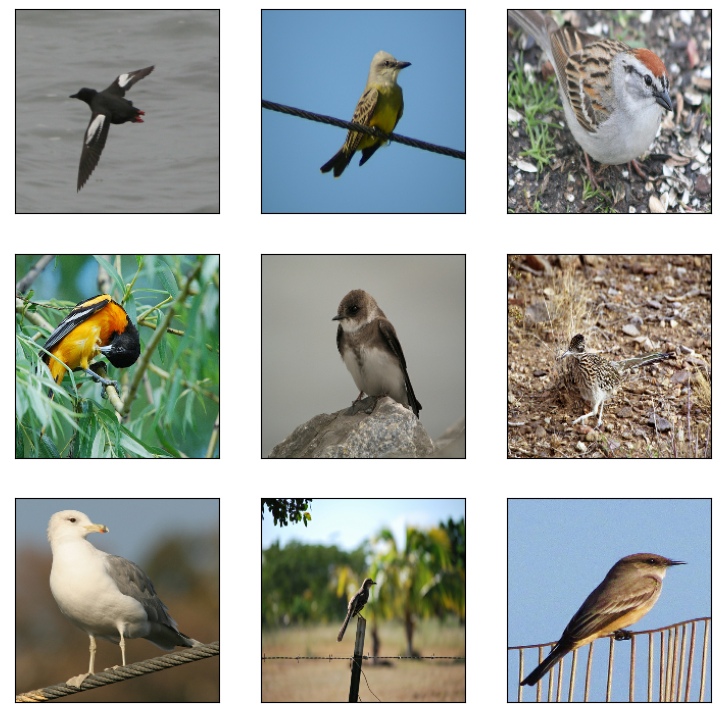

In [161]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


In [116]:
def build_model():
    backbone = resnet.ResNet50(weights="imagenet", input_shape=(200,200,3),include_top=False)
    x = layers.Flatten()(backbone.output)
    x = layers.Dense(400, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(200, activation="relu")(x)
    model = Model(inputs=backbone.input, outputs=output)
    return model


In [39]:
## distance layer 

In [40]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [41]:
model = build_model()
trainable = False
for layer in model.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

    

In [42]:
# siamese network 
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    model(resnet.preprocess_input(anchor_input)),
    model(resnet.preprocess_input(positive_input)),
    model(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [44]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [162]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)


Epoch 1/10


2023-02-09 02:40:49.745636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-09 02:40:53.111705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-09 02:40:53.331248: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc370350360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-09 02:40:53.331285: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2023-02-09 02:40:53.345401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-09 02:40:53.536111: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for th

147/147 [==============================] - 53s 255ms/step - loss: 0.5267 - val_loss: 0.5043
Epoch 2/10
147/147 [==============================] - 32s 216ms/step - loss: 0.5061 - val_loss: 0.4953
Epoch 3/10
147/147 [==============================] - 32s 220ms/step - loss: 0.4996 - val_loss: 0.4984
Epoch 4/10
147/147 [==============================] - 32s 219ms/step - loss: 0.4993 - val_loss: 0.4997
Epoch 5/10
147/147 [==============================] - 32s 219ms/step - loss: 0.4967 - val_loss: 0.4991
Epoch 6/10
147/147 [==============================] - 32s 221ms/step - loss: 0.4986 - val_loss: 0.4989
Epoch 7/10
147/147 [==============================] - 32s 221ms/step - loss: 0.5008 - val_loss: 0.5053
Epoch 8/10
147/147 [==============================] - 32s 221ms/step - loss: 0.4949 - val_loss: 0.5039
Epoch 9/10
147/147 [==============================] - 32s 220ms/step - loss: 0.4954 - val_loss: 0.5027
Epoch 10/10
147/147 [==============================] - 32s 221ms/step - loss: 0.4903

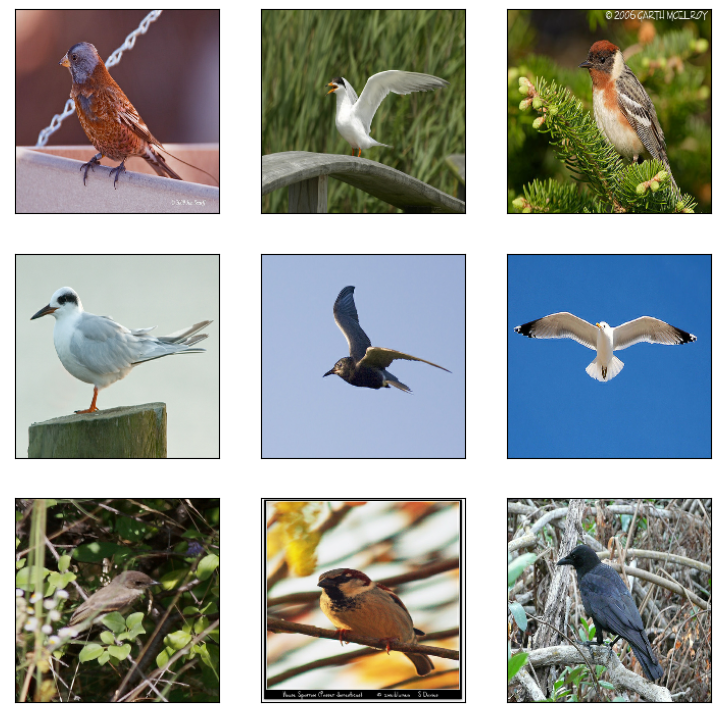

In [164]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    model(resnet.preprocess_input(anchor)),
    model(resnet.preprocess_input(positive)),
    model(resnet.preprocess_input(negative)),
)


In [165]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9987656
Negative similarity 0.99857134
